## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import tensorflow as tf
from keras.layers import Flatten, Dense, Input, Dropout, Conv1D, BatchNormalization, MaxPooling1D, Flatten, LSTM, Bidirectional, Embedding, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop, Adamax

import ast

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

## Data analysis

### Training data

In [2]:
train_data = pd.read_csv('data/labelled_training_data.csv')
train_data.shape

(763144, 16)

In [3]:
train_data.head()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,381,7337,1,100,4026532231,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,381,7337,1,100,4026532231,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,381,7337,1,100,4026532231,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,21,access,[],2,-2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


#### Sus

In [4]:
train_data['sus'].value_counts()

sus
0    761875
1      1269
Name: count, dtype: int64

#### Malicious

In [5]:
train_data['evil'].value_counts()

evil
0    763144
Name: count, dtype: int64

#### User id

In [6]:
train_data['userId'].value_counts()

userId
0       754907
101       3398
109       1476
102       1208
100       1148
1000       996
103         11
Name: count, dtype: int64

#### Hostname

In [7]:
train_data['hostName'].value_counts()

hostName
ubuntu             190500
ip-10-100-1-57     162378
ip-10-100-1-120     95747
ip-10-100-1-28      75648
ip-10-100-1-55      75208
ip-10-100-1-173     74593
ip-10-100-1-34      73295
ip-10-100-1-79      15775
Name: count, dtype: int64

### Validation data

In [8]:
val_data = pd.read_csv('data/labelled_validation_data.csv')
val_data.shape

(188967, 16)

In [9]:
val_data.head()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,124.439221,381,381,1,101,4026532232,systemd-resolve,ip-10-100-1-129,41,socket,"[139913106282763, 139913103116537, 94901962555...",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
1,124.439751,378,378,1,100,4026532231,systemd-network,ip-10-100-1-129,41,socket,"[140343254628619, 93967981149065, 93967990898192]",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
2,124.439958,1,1,0,0,4026531840,systemd,ip-10-100-1-129,1005,security_file_open,"[140074839310116, 8103505641674583864]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
3,124.440007,1,1,0,0,4026531840,systemd,ip-10-100-1-129,257,openat,[],4,12,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
4,124.440037,1,1,0,0,4026531840,systemd,ip-10-100-1-129,5,fstat,[140074839307913],2,0,"[{'name': 'fd', 'type': 'int', 'value': 12}, {...",0,0


#### Suspicious

In [10]:
val_data['sus'].value_counts()

sus
0    188181
1       786
Name: count, dtype: int64

#### Malicious

In [11]:
val_data['evil'].value_counts()

evil
0    188967
Name: count, dtype: int64

### Testing data

In [12]:
test_data = pd.read_csv('data/labelled_testing_data.csv')
test_data.shape

(188967, 16)

In [13]:
test_data.head()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,129.050634,382,382,1,101,4026532232,systemd-resolve,ip-10-100-1-217,41,socket,"[140159195621643, 140159192455417, 94656731598...",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
1,129.051238,379,379,1,100,4026532231,systemd-network,ip-10-100-1-217,41,socket,"[139853228042507, 93935071185801, 93935080775184]",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
2,129.051434,1,1,0,0,4026531840,systemd,ip-10-100-1-217,1005,security_file_open,"[140362867191588, 8103505641674583858]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
3,129.051481,1,1,0,0,4026531840,systemd,ip-10-100-1-217,257,openat,[],4,17,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
4,129.051522,1,1,0,0,4026531840,systemd,ip-10-100-1-217,5,fstat,[140362867189385],2,0,"[{'name': 'fd', 'type': 'int', 'value': 17}, {...",0,0


#### Suspicious

In [14]:
test_data['sus'].value_counts()

sus
1    171459
0     17508
Name: count, dtype: int64

#### Malicious

In [15]:
test_data['evil'].value_counts()

evil
1    158432
0     30535
Name: count, dtype: int64

### 2021may-ip-10-100-1-4

#### labelled_2021may-ip-10-100-1-4-dns

In [16]:
dns_file1 = pd.read_csv('data/labelled_2021may-ip-10-100-1-4-dns.csv')
dns_file1.shape

(269, 15)

In [17]:
dns_file1.head()

,Timestamp,SourceIP,DestinationIP,DnsQuery,DnsAnswer,DnsAnswerTTL,DnsQueryNames,DnsQueryClass,DnsQueryType,NumberOfAnswers,DnsResponseCode,DnsOpCode,SensorId,sus,evil
0,2021-05-16T17:13:14Z,10.100.1.95,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['A'],0,0,0,ip-10-100-1-95,0,0
1,2021-05-16T17:13:14Z,10.100.0.2,10.100.1.95,ssm.us-east-2.amazonaws.com,['52.95.19.240'],['17'],ssm.us-east-2.amazonaws.com,['IN'],['A'],1,0,0,ip-10-100-1-95,0,0
2,2021-05-16T17:13:14Z,10.100.1.95,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['AAAA'],0,0,0,ip-10-100-1-95,0,0
3,2021-05-16T17:13:14Z,10.100.0.2,10.100.1.95,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['AAAA'],0,0,0,ip-10-100-1-95,0,0
4,2021-05-16T17:13:16Z,10.100.1.186,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['A'],0,0,0,ip-10-100-1-186,0,0


#### labelled_2021may-ip-10-100-1-4

In [18]:
file1 = pd.read_csv('data/labelled_2021may-ip-10-100-1-4.csv')
file1.shape

(485241, 13)

In [19]:
file1.head()

,timestamp,processId,parentProcessId,userId,processName,hostName,eventId,eventName,argsNum,returnValue,args,sus,evil
0,131.874057,382,1,101,systemd-resolve,ip-10-100-1-4,1005,security_file_open,4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
1,131.874597,382,1,101,systemd-resolve,ip-10-100-1-4,257,openat,4,15,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
2,131.874796,382,1,101,systemd-resolve,ip-10-100-1-4,5,fstat,2,0,"[{'name': 'fd', 'type': 'int', 'value': 15}, {...",0,0
3,131.874743,382,1,101,systemd-resolve,ip-10-100-1-4,5,fstat,2,0,"[{'name': 'fd', 'type': 'int', 'value': 15}, {...",0,0
4,131.874975,382,1,101,systemd-resolve,ip-10-100-1-4,3,close,1,0,"[{'name': 'fd', 'type': 'int', 'value': 15}]",0,0


In [20]:
print(f"Min timestamp: {min(file1['timestamp'])}")
print(f"Max timestamp: {max(file1['timestamp'])}")

Min timestamp: 131.874057
Max timestamp: 16350.99039


### labelled_2021may-ip-10-100-1-95

In [21]:
dns_file2 = pd.read_csv('data/labelled_2021may-ip-10-100-1-95-dns.csv')
dns_file2.shape

(269, 15)

In [22]:
dns_file2.head()

,Timestamp,SourceIP,DestinationIP,DnsQuery,DnsAnswer,DnsAnswerTTL,DnsQueryNames,DnsQueryClass,DnsQueryType,NumberOfAnswers,DnsResponseCode,DnsOpCode,SensorId,sus,evil
0,2021-05-16T17:13:14Z,10.100.1.95,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['A'],0,0,0,ip-10-100-1-95,0,0
1,2021-05-16T17:13:14Z,10.100.0.2,10.100.1.95,ssm.us-east-2.amazonaws.com,['52.95.19.240'],['17'],ssm.us-east-2.amazonaws.com,['IN'],['A'],1,0,0,ip-10-100-1-95,0,0
2,2021-05-16T17:13:14Z,10.100.1.95,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['AAAA'],0,0,0,ip-10-100-1-95,0,0
3,2021-05-16T17:13:14Z,10.100.0.2,10.100.1.95,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['AAAA'],0,0,0,ip-10-100-1-95,0,0
4,2021-05-16T17:13:16Z,10.100.1.186,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['A'],0,0,0,ip-10-100-1-186,0,0


In [23]:
file2 = pd.read_csv('data/labelled_2021may-ip-10-100-1-95.csv')
file2.shape

(479433, 13)

In [24]:
file2.head()

,timestamp,processId,parentProcessId,userId,processName,hostName,eventId,eventName,argsNum,returnValue,args,sus,evil
0,125.462475,386,1,101,systemd-resolve,ip-10-100-1-95,1005,security_file_open,4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
1,125.462882,386,1,101,systemd-resolve,ip-10-100-1-95,257,openat,4,15,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
2,125.463018,386,1,101,systemd-resolve,ip-10-100-1-95,5,fstat,2,0,"[{'name': 'fd', 'type': 'int', 'value': 15}, {...",0,0
3,125.463228,386,1,101,systemd-resolve,ip-10-100-1-95,3,close,1,0,"[{'name': 'fd', 'type': 'int', 'value': 15}]",0,0
4,125.463065,386,1,101,systemd-resolve,ip-10-100-1-95,5,fstat,2,0,"[{'name': 'fd', 'type': 'int', 'value': 15}, {...",0,0


#### User ID

In [25]:
file2['userId'].value_counts()

userId
0       457174
105      15711
101       2279
104       1414
109       1287
100        849
1000       568
103        151
Name: count, dtype: int64

#### Process ID

In [26]:
file2['processId'].value_counts()

processId
159     25282
1        7682
8005     6668
8505     5788
8479     4495
        ...  
7975        1
7552        1
7809        1
7390        1
7579        1
Name: count, Length: 1124, dtype: int64

#### Process Name

In [27]:
file2['processName'].value_counts()

processName
ps                 312920
sshd                49385
systemd-journal     25224
apt-config          10580
lsb_release          8520
                    ...  
docker                  1
dockerd                 1
containerd-shim         1
(sd-pam)                1
terraform_21167         1
Name: count, Length: 92, dtype: int64

#### Events frequency

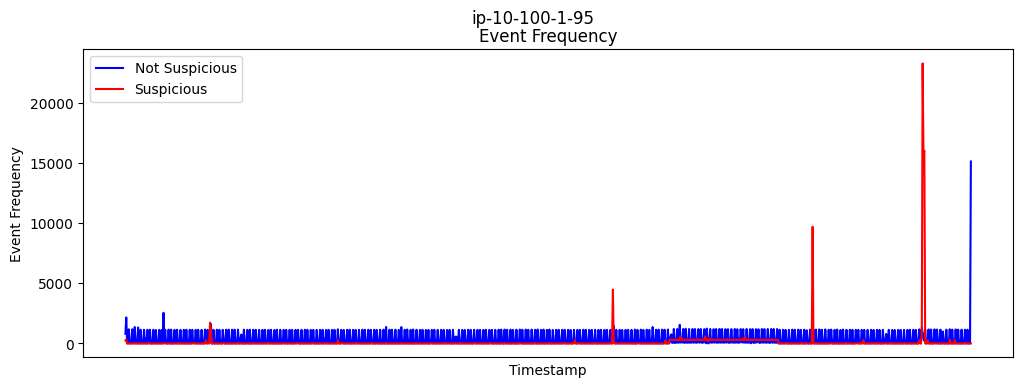

In [28]:
# df = file2[file2['userId']==0]
df=file2

bins = pd.cut(df['timestamp'], bins=1000)
event_counts_notsus = df[df['sus']==0].groupby(bins).size()
event_counts_sus = df[df['sus']==1].groupby(bins).size()
event_counts_notsus.plot(kind='line', color='blue', label='Not Suspicious', figsize=(12, 4))
event_counts_sus.plot(kind='line', color='red', label='Suspicious')
plt.xlabel('Timestamp')
plt.ylabel('Event Frequency')
plt.title('Event Frequency')
plt.suptitle('ip-10-100-1-95')
plt.xticks([])
plt.legend()
plt.show()

### ip-10-100-1-186

In [29]:
dns_file3 = pd.read_csv('data/labelled_2021may-ip-10-100-1-186-dns.csv')
dns_file3.shape

(269, 15)

In [30]:
dns_file3.head()

,Timestamp,SourceIP,DestinationIP,DnsQuery,DnsAnswer,DnsAnswerTTL,DnsQueryNames,DnsQueryClass,DnsQueryType,NumberOfAnswers,DnsResponseCode,DnsOpCode,SensorId,sus,evil
0,2021-05-16T17:13:14Z,10.100.1.95,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['A'],0,0,0,ip-10-100-1-95,0,0
1,2021-05-16T17:13:14Z,10.100.0.2,10.100.1.95,ssm.us-east-2.amazonaws.com,['52.95.19.240'],['17'],ssm.us-east-2.amazonaws.com,['IN'],['A'],1,0,0,ip-10-100-1-95,0,0
2,2021-05-16T17:13:14Z,10.100.1.95,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['AAAA'],0,0,0,ip-10-100-1-95,0,0
3,2021-05-16T17:13:14Z,10.100.0.2,10.100.1.95,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['AAAA'],0,0,0,ip-10-100-1-95,0,0
4,2021-05-16T17:13:16Z,10.100.1.186,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['A'],0,0,0,ip-10-100-1-186,0,0


In [31]:
file3 = pd.read_csv('data/labelled_2021may-ip-10-100-1-186.csv')
file3.shape

(713867, 13)

In [32]:
file3[file3['sus']==1].head()

,timestamp,processId,parentProcessId,userId,processName,hostName,eventId,eventName,argsNum,returnValue,args,sus,evil
67,125.595818,7285,1368,1000,sleep,ip-10-100-1-186,3,close,1,0,"[{'name': 'fd', 'type': 'int', 'value': 1}]",1,0
68,125.595860,7285,1368,1000,sleep,ip-10-100-1-186,3,close,1,0,"[{'name': 'fd', 'type': 'int', 'value': 2}]",1,0
69,125.595990,7285,1368,1000,sleep,ip-10-100-1-186,1010,sched_process_exit,0,0,[],1,0
70,125.596139,1368,1355,1000,terraform_10402,ip-10-100-1-186,1010,sched_process_exit,0,0,[],1,0
71,125.597087,1355,1282,1000,sshd,ip-10-100-1-186,3,close,1,0,"[{'name': 'fd', 'type': 'int', 'value': 13}]",1,0


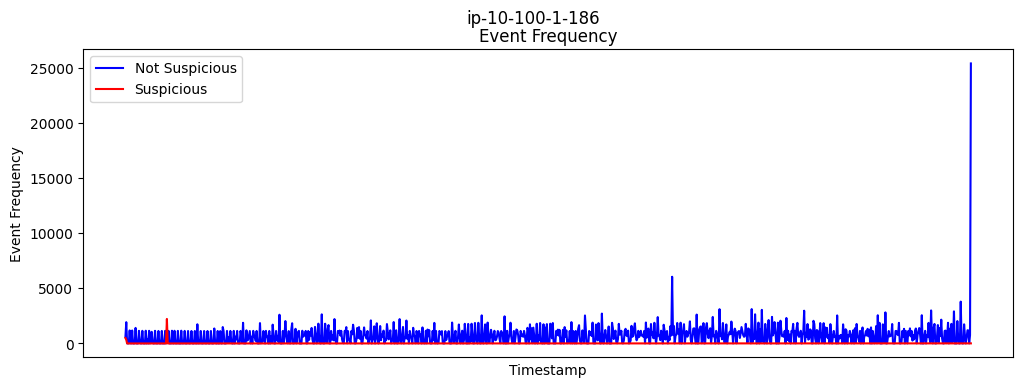

In [33]:
# df = file2[file2['userId']==0]
df=file3

bins = pd.cut(df['timestamp'], bins=1000)
event_counts_notsus = df[df['sus']==0].groupby(bins).size()
event_counts_sus = df[df['sus']==1].groupby(bins).size()
event_counts_notsus.plot(kind='line', color='blue', label='Not Suspicious', figsize=(12, 4))
event_counts_sus.plot(kind='line', color='red', label='Suspicious')
plt.xlabel('Timestamp')
plt.ylabel('Event Frequency')
plt.title('Event Frequency')
plt.suptitle('ip-10-100-1-186')
plt.xticks([])
plt.legend()
plt.show()

## Correlation matrix

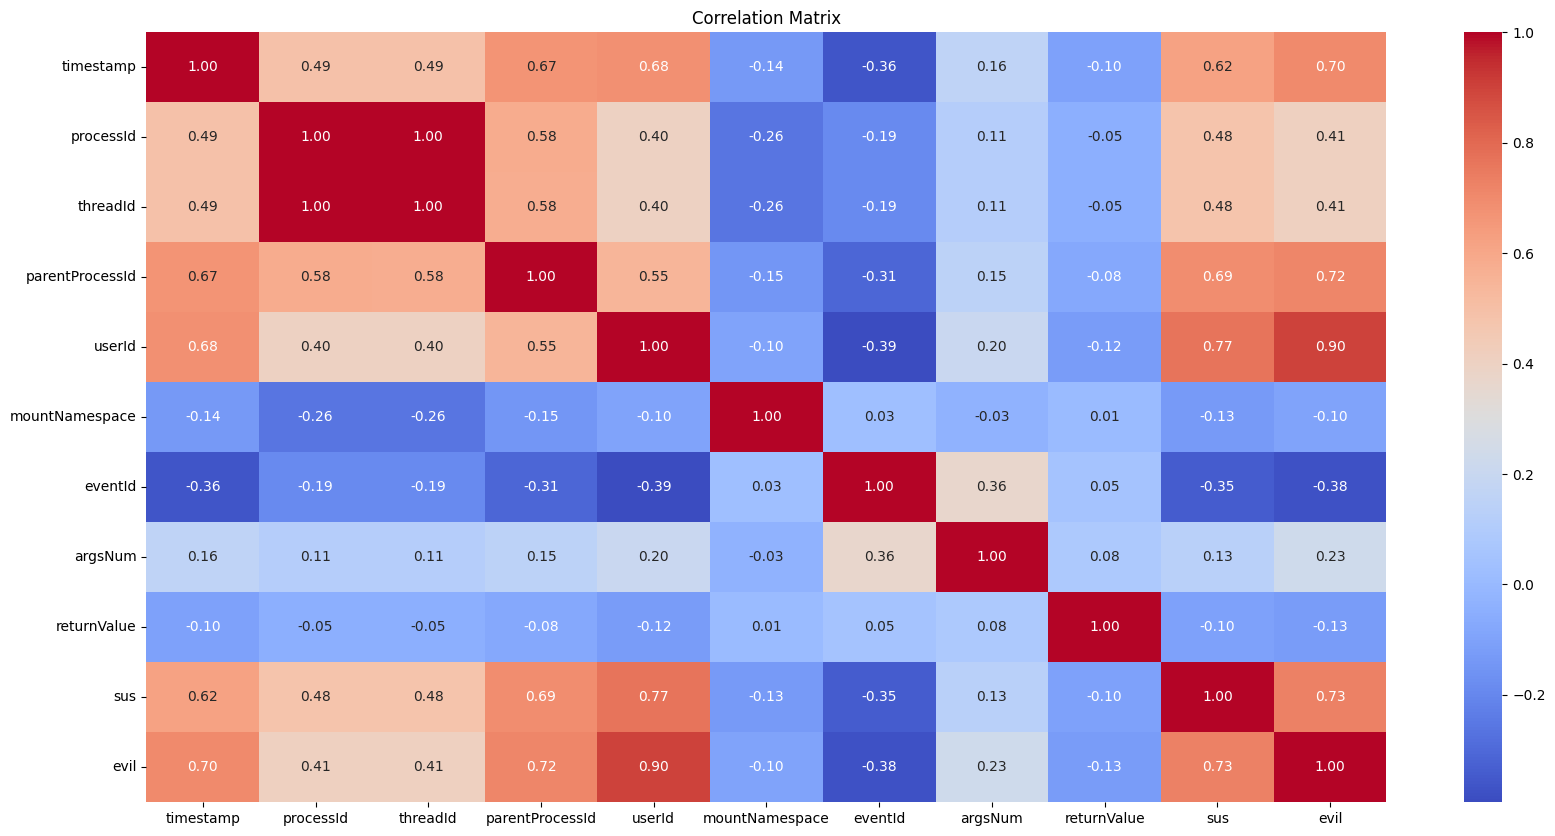

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = test_data.select_dtypes(include=['int64','float64']).corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

## Data preparation

In [35]:
train_data["processId"] = train_data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_data["parentProcessId"] = train_data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_data["userId"] = train_data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
train_data["mountNamespace"] = train_data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
train_data["eventId"] = train_data["eventId"]  # Keep eventId values (requires knowing max value)
train_data["returnValue"] = train_data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))


val_data["processId"] = val_data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
val_data["parentProcessId"] = val_data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
val_data["userId"] = val_data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
val_data["mountNamespace"] = val_data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
val_data["eventId"] = val_data["eventId"]  # Keep eventId values (requires knowing max value)
val_data["returnValue"] = val_data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2)) 


test_data["processId"] = test_data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
test_data["parentProcessId"] = test_data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
test_data["userId"] = test_data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
test_data["mountNamespace"] = test_data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
test_data["eventId"] = test_data["eventId"]  # Keep eventId values (requires knowing max value)
test_data["returnValue"] = test_data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2)) 

In [36]:
train_data.describe()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus,evil
count,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.0
mean,1844.582673,0.978617,6820.265241,0.895755,0.001305,0.256371,288.158953,2.672082,0.340016,0.001663,0.0
std,1136.638249,0.144656,1937.068333,0.305578,0.036103,0.436629,385.117778,1.340906,0.533623,0.040744,0.0
min,132.560721,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.0
25%,903.250802,1.000000,7313.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.0
50%,1829.203642,1.000000,7365.000000,1.000000,0.000000,0.000000,62.000000,3.000000,0.000000,0.000000,0.0
75%,2761.380825,1.000000,7415.000000,1.000000,0.000000,1.000000,257.000000,4.000000,1.000000,0.000000,0.0
max,3954.587643,1.000000,8619.000000,1.000000,1.000000,1.000000,1010.000000,5.000000,2.000000,1.000000,0.0


In [37]:
train_data.dtypes

timestamp          float64
processId            int64
threadId             int64
parentProcessId      int64
userId               int64
mountNamespace       int64
processName         object
hostName            object
eventId              int64
eventName           object
stackAddresses      object
argsNum              int64
returnValue          int64
args                object
sus                  int64
evil                 int64
dtype: object

### **Stackaddress**

In [38]:
stack_addresses_df = pd.concat([train_data['stackAddresses'], val_data['stackAddresses'], test_data['stackAddresses']], axis=0)
len(stack_addresses_df.unique())

112474

In [39]:
stack_addresses_df

0         [140662171848350, 11649800180280676]
1                            [140662171777451]
2                                           []
3                                           []
4           [139778263990104, 139778263906698]
                          ...                 
188962                                      []
188963                                      []
188964                                      []
188965                                      []
188966                                      []
Name: stackAddresses, Length: 1141078, dtype: object

**Convert String to List**

In [40]:
# Convert string to list
train_data.stackAddresses = train_data.stackAddresses.apply(ast.literal_eval)
val_data.stackAddresses = val_data.stackAddresses.apply(ast.literal_eval)
test_data.stackAddresses = test_data.stackAddresses.apply(ast.literal_eval)
train_data.stackAddresses[0]

[140662171848350, 11649800180280676]

In [41]:
train_data['stack_address_len']=train_data.stackAddresses.apply(len)
val_data['stack_address_len']=val_data.stackAddresses.apply(len)
test_data['stack_address_len']=test_data.stackAddresses.apply(len)
print(f"Training dataset - Max length of stack addresses: {max(train_data['stack_address_len'])}")
print(f"Validation dataset - Max length of stack addresses: {max(val_data['stack_address_len'])}")
print(f"Testing dataset - Max length of stack addresses: {max(test_data['stack_address_len'])}")

Training dataset - Max length of stack addresses: 20
Validation dataset - Max length of stack addresses: 20
Testing dataset - Max length of stack addresses: 20


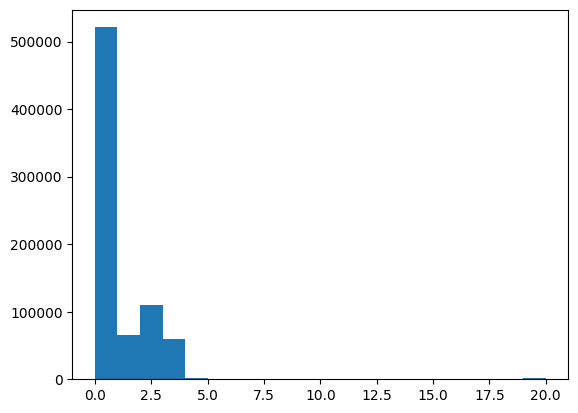

In [42]:
plt.hist(train_data['stack_address_len'], bins=20);

In [43]:
train_data['stack_address_len'].value_counts()

stack_address_len
0     521115
2     109594
1      65545
3      59301
4       2445
20      1406
14      1073
15       932
6        354
8        347
17       276
10       206
11       190
9        143
5         92
16        90
12        27
7          8
Name: count, dtype: int64

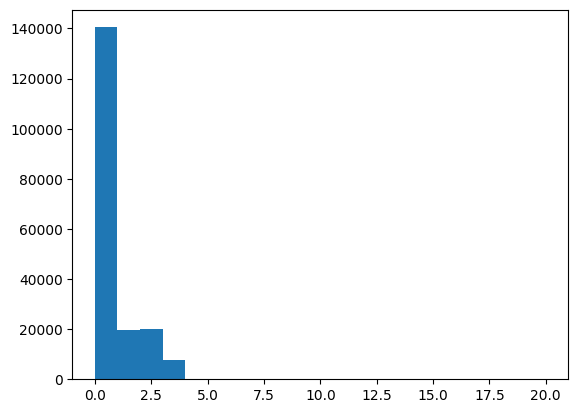

In [44]:
plt.hist(val_data['stack_address_len'], bins=20);

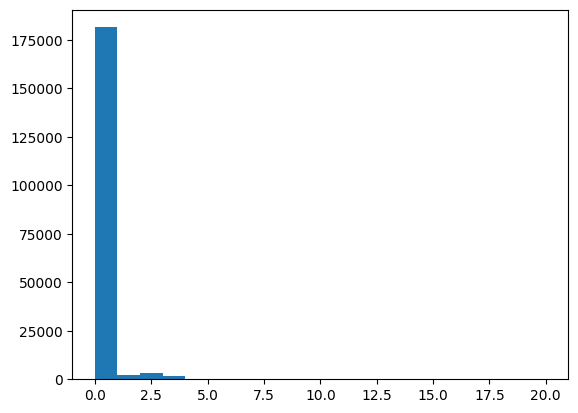

In [45]:
plt.hist(test_data['stack_address_len'], bins=20);

**Split list**

In [46]:
for i in range(max(train_data['stack_address_len'])):
    train_data[f"stack_{i+1}"]=""
    val_data[f"stack_{i+1}"]=""
    test_data[f"stack_{i+1}"]=""

In [47]:
for index, row in train_data.iterrows():
    list_stack = [float(elem) for elem in row['stackAddresses']]
    for i, elem in enumerate(list_stack):
        train_data.at[index, f'stack_{i+1}'] = elem

for index, row in val_data.iterrows():
    list_stack = [float(elem) for elem in row['stackAddresses']]
    for i, elem in enumerate(list_stack):
        val_data.at[index, f'stack_{i+1}'] = elem


for index, row in test_data.iterrows():
    list_stack = [float(elem) for elem in row['stackAddresses']]
    for i, elem in enumerate(list_stack):
        test_data.at[index, f'stack_{i+1}'] = elem

In [48]:
train_data.loc[0]

timestamp                                                  1809.495787
processId                                                            1
threadId                                                          7337
parentProcessId                                                      0
userId                                                               0
mountNamespace                                                       1
processName                                                      close
hostName                                               ip-10-100-1-120
eventId                                                            157
eventName                                                        prctl
stackAddresses                    [140662171848350, 11649800180280676]
argsNum                                                              5
returnValue                                                          0
args                 [{'name': 'option', 'type': 'int', 'value': 'P...
sus   

**Args**

In [49]:
train_data['argsNum'].value_counts()

argsNum
4    359113
1    230609
2    149273
3     20062
5      2678
0      1409
Name: count, dtype: int64

In [50]:
len(train_data['args'].unique())

214720

In [51]:
train_data['args'][4]

"[{'name': 'pathname', 'type': 'const char*', 'value': '/etc/ld.so.cache'}, {'name': 'flags', 'type': 'int', 'value': 'O_RDONLY|O_LARGEFILE'}, {'name': 'dev', 'type': 'dev_t', 'value': 211812353}, {'name': 'inode', 'type': 'unsigned long', 'value': 62841}]"

**Split args**

In [52]:
# Function to split the string column into list of dictionaries and create new columns
def split_and_expand(row):
    if pd.isna(row):
        return pd.Series([None] * 15)

    dicts = ast.literal_eval(row)
    result = {'name_{}'.format(i+1): None for i in range(5)}
    result.update({'type_{}'.format(i+1): None for i in range(5)})
    result.update({'value_{}'.format(i+1): None for i in range(5)})

    for i, d in enumerate(dicts):
        if i >= 5:
            break
        result['name_{}'.format(i+1)] = d.get('name')
        result['type_{}'.format(i+1)] = d.get('type')
        result['value_{}'.format(i+1)] = d.get('value')

    return pd.Series(result)

Training

In [53]:
args_split = train_data['args'].apply(split_and_expand)
train_data = pd.concat([train_data, args_split], axis=1)

Validation

In [54]:
args_split = val_data['args'].apply(split_and_expand)
val_data = pd.concat([val_data, args_split], axis=1)

Testing

In [55]:
args_split = test_data['args'].apply(split_and_expand)
test_data = pd.concat([test_data, args_split], axis=1)

In [56]:
train_data.columns

Index(['timestamp', 'processId', 'threadId', 'parentProcessId', 'userId',
       'mountNamespace', 'processName', 'hostName', 'eventId', 'eventName',
       'stackAddresses', 'argsNum', 'returnValue', 'args', 'sus', 'evil',
       'stack_address_len', 'stack_1', 'stack_2', 'stack_3', 'stack_4',
       'stack_5', 'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
       'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15', 'stack_16',
       'stack_17', 'stack_18', 'stack_19', 'stack_20', 'name_1', 'name_2',
       'name_3', 'name_4', 'name_5', 'type_1', 'type_2', 'type_3', 'type_4',
       'type_5', 'value_1', 'value_2', 'value_3', 'value_4', 'value_5'],
      dtype='object')

In [57]:
train_data.dtypes

timestamp            float64
processId              int64
threadId               int64
parentProcessId        int64
userId                 int64
mountNamespace         int64
processName           object
hostName              object
eventId                int64
eventName             object
stackAddresses        object
argsNum                int64
returnValue            int64
args                  object
sus                    int64
evil                   int64
stack_address_len      int64
stack_1               object
stack_2               object
stack_3               object
stack_4               object
stack_5               object
stack_6               object
stack_7               object
stack_8               object
stack_9               object
stack_10              object
stack_11              object
stack_12              object
stack_13              object
stack_14              object
stack_15              object
stack_16              object
stack_17              object
stack_18      

**Features selection**

In [58]:
# data1 = train_data.sample(frac=0.4, ignore_index=True)

X_num_train = train_data[['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'argsNum', 'returnValue', 'stack_address_len']]
X_cat_train = train_data[['processName', 'hostName', 'eventName',
                     'stack_1', 'stack_2', 'stack_3', 'stack_4',
                     'stack_5', 'stack_6', 'stack_7', 'stack_8', 'stack_9', 
                     'stack_10','stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                     'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20',
                     'name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                     'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                     'value_1', 'value_2', 'value_3', 'value_4', 'value_5']].astype(str)

In [59]:
X_num_val = val_data[['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'argsNum', 'returnValue', 'stack_address_len']]
X_cat_val = val_data[['processName', 'hostName', 'eventName',
                     'stack_1', 'stack_2', 'stack_3', 'stack_4',
                     'stack_5', 'stack_6', 'stack_7', 'stack_8', 'stack_9', 
                     'stack_10','stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                     'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20',
                     'name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                     'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                     'value_1', 'value_2', 'value_3', 'value_4', 'value_5']].astype(str)

In [60]:
X_num_test = test_data[['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'argsNum', 'returnValue', 'stack_address_len']]
X_cat_test = test_data[['processName', 'hostName', 'eventName',
                     'stack_1', 'stack_2', 'stack_3', 'stack_4',
                     'stack_5', 'stack_6', 'stack_7', 'stack_8', 'stack_9', 
                     'stack_10','stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                     'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20',
                     'name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                     'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                     'value_1', 'value_2', 'value_3', 'value_4', 'value_5']].astype(str)

**Categorical features encoding**

Stack addresses

In [61]:
stack_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', 
                                 unknown_value=-1, dtype=float)

# Encode Stack adresses
stackaddresses_train_enc = stack_ordinal_encoder.fit_transform(X_cat_train[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                                                      'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                                                      'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                                                      'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']])

In [62]:
np.min(stackaddresses_train_enc), np.max(stackaddresses_train_enc)

(0.0, 8447.0)

In [63]:
X_cat_train[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
             'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
             'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
             'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']] = stackaddresses_train_enc

In [64]:
stackaddresses_val_enc = stack_ordinal_encoder.transform(X_cat_val[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                                        'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                                        'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                                        'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']])

In [65]:
np.min(stackaddresses_val_enc), np.max(stackaddresses_val_enc)

(-1.0, 8375.0)

In [66]:
stackaddresses_val_enc = np.where(stackaddresses_val_enc==-1, np.max(stackaddresses_train_enc)+1, stackaddresses_val_enc)

In [67]:
np.min(stackaddresses_val_enc), np.max(stackaddresses_val_enc)

(0.0, 8448.0)

In [68]:
X_cat_val[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
           'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
           'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
           'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']]= stackaddresses_val_enc

In [69]:
X_cat_val.iloc[4,4]

0.0

In [70]:
stackaddresses_test_enc = stack_ordinal_encoder.transform(X_cat_test[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                                        'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                                        'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                                        'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']])

stackaddresses_test_enc = np.where(stackaddresses_test_enc==-1, np.max(stackaddresses_train_enc)+1, stackaddresses_test_enc)

X_cat_test[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
           'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
           'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
           'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']]= stackaddresses_test_enc

In [71]:
X_cat_test.dtypes

processName     object
hostName        object
eventName       object
stack_1        float64
stack_2        float64
stack_3        float64
stack_4        float64
stack_5        float64
stack_6        float64
stack_7        float64
stack_8        float64
stack_9        float64
stack_10       float64
stack_11       float64
stack_12       float64
stack_13       float64
stack_14       float64
stack_15       float64
stack_16       float64
stack_17       float64
stack_18       float64
stack_19       float64
stack_20       float64
name_1          object
name_2          object
name_3          object
name_4          object
name_5          object
type_1          object
type_2          object
type_3          object
type_4          object
type_5          object
value_1         object
value_2         object
value_3         object
value_4         object
value_5         object
dtype: object

Args

In [72]:
# Encode Stack adresses
args_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=float)
args_train_enc = args_ordinal_encoder.fit_transform(X_cat_train[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                                            'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                                            'value_1', 'value_2', 'value_3', 'value_4', 'value_5']])
X_cat_train[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
             'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
             'value_1', 'value_2', 'value_3', 'value_4', 'value_5']] = args_train_enc

In [73]:
np.min(args_train_enc), np.max(args_train_enc)

(0.0, 26663.0)

In [74]:
args_val_enc = args_ordinal_encoder.transform(X_cat_val[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                                    'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                                    'value_1', 'value_2', 'value_3', 'value_4', 'value_5']])

args_val_enc = np.where(args_val_enc==-1, np.max(args_train_enc)+1, args_val_enc)

X_cat_val[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
           'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
           'value_1', 'value_2', 'value_3', 'value_4', 'value_5']] = args_val_enc

In [75]:
args_test_enc = args_ordinal_encoder.transform(X_cat_test[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                                      'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                                      'value_1', 'value_2', 'value_3', 'value_4', 'value_5']])

args_test_enc = np.where(args_test_enc==-1, np.max(args_train_enc)+1, args_test_enc)

X_cat_test[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
           'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
           'value_1', 'value_2', 'value_3', 'value_4', 'value_5']] = args_test_enc

ProcessName

In [76]:
proc_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=float)
X_cat_train['processName'] = proc_ordinal_encoder.fit_transform(X_cat_train[['processName']])

In [77]:
min(X_cat_train['processName']), max(X_cat_train['processName'])

(0.0, 35.0)

In [78]:
processName_val_enc = proc_ordinal_encoder.transform(X_cat_val[['processName']])
processName_val_enc = np.where(processName_val_enc==-1, np.max(X_cat_train['processName'])+1, processName_val_enc)
X_cat_val['processName'] = processName_val_enc

In [79]:
processName_test_enc = proc_ordinal_encoder.transform(X_cat_test[['processName']])
processName_test_enc = np.where(processName_test_enc==-1, np.max(X_cat_train['processName'])+1, processName_test_enc)
X_cat_test['processName'] = processName_test_enc

HostName

In [80]:
host_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=float)
X_cat_train['hostName'] = host_ordinal_encoder.fit_transform(X_cat_train[['hostName']])

host_val_enc = host_ordinal_encoder.transform(X_cat_val[['hostName']])
host_val_enc = np.where(host_val_enc==-1, np.max(X_cat_train['hostName'])+1, host_val_enc)
X_cat_val['hostName'] = host_val_enc

host_test_enc = host_ordinal_encoder.transform(X_cat_test[['hostName']])
host_test_enc = np.where(host_test_enc==-1, np.max(X_cat_train['hostName'])+1, host_test_enc)
X_cat_test['hostName'] = host_test_enc

EventName

In [81]:
event_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=float)
X_cat_train['eventName'] = event_ordinal_encoder.fit_transform(X_cat_train[['eventName']])

event_val_enc = event_ordinal_encoder.transform(X_cat_val[['eventName']])
event_val_enc = np.where(event_val_enc==-1, np.max(X_cat_train['eventName'])+1, event_val_enc)
X_cat_val['eventName'] = event_val_enc

event_test_enc = event_ordinal_encoder.transform(X_cat_test[['eventName']])
event_test_enc = np.where(event_test_enc==-1, np.max(X_cat_train['eventName'])+1, event_test_enc)
X_cat_test['eventName'] = event_test_enc

In [82]:
X_cat_train.loc[2]

processName        6.0
hostName           0.0
eventName         20.0
stack_1            0.0
stack_2            0.0
stack_3            0.0
stack_4            0.0
stack_5            0.0
stack_6            0.0
stack_7            0.0
stack_8            0.0
stack_9            0.0
stack_10           0.0
stack_11           0.0
stack_12           0.0
stack_13           0.0
stack_14           0.0
stack_15           0.0
stack_16           0.0
stack_17           0.0
stack_18           0.0
stack_19           0.0
stack_20           0.0
name_1             0.0
name_2             0.0
name_3             0.0
name_4             0.0
name_5             0.0
type_1             0.0
type_2             0.0
type_3             0.0
type_4             0.0
type_5             0.0
value_1         5993.0
value_2        25566.0
value_3         1701.0
value_4         8170.0
value_5           34.0
Name: 2, dtype: float64

In [83]:
X_num_train.shape

(763144, 9)

In [84]:
X_train = pd.concat([X_num_train, X_cat_train], axis=1)
y_train = train_data['sus']
X_train.shape

(763144, 47)

In [85]:
X_val = pd.concat([X_num_val, X_cat_val], axis=1)
y_val = val_data['sus']

In [86]:
X_test = pd.concat([X_num_test, X_cat_test], axis=1)
y_test = test_data['sus']

In [87]:
X_val.dtypes

processId              int64
threadId               int64
parentProcessId        int64
userId                 int64
mountNamespace         int64
eventId                int64
argsNum                int64
returnValue            int64
stack_address_len      int64
processName          float64
hostName             float64
eventName            float64
stack_1              float64
stack_2              float64
stack_3              float64
stack_4              float64
stack_5              float64
stack_6              float64
stack_7              float64
stack_8              float64
stack_9              float64
stack_10             float64
stack_11             float64
stack_12             float64
stack_13             float64
stack_14             float64
stack_15             float64
stack_16             float64
stack_17             float64
stack_18             float64
stack_19             float64
stack_20             float64
name_1               float64
name_2               float64
name_3        

## Principal components

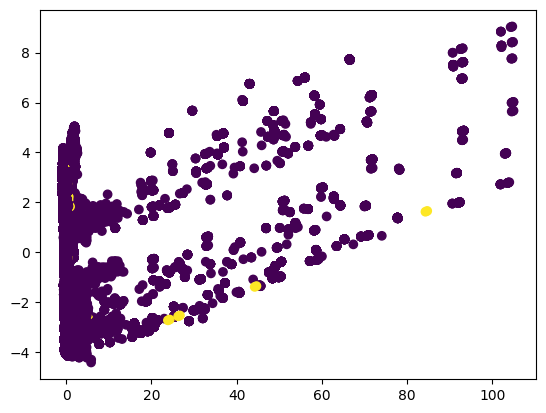

In [88]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=47, svd_solver='auto')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

Xt = pca.fit_transform(X_train_scaled)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_train)
plt.show()

In [89]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[1.37732738e+01 7.53350801e+00 3.89274051e+00 3.30539769e+00
 2.77418389e+00 2.37592904e+00 2.22449849e+00 2.06286811e+00
 1.59557546e+00 1.00533847e+00 8.17003322e-01 6.13127829e-01
 5.54256802e-01 4.86976021e-01 4.59041962e-01 3.94777028e-01
 3.68966650e-01 3.16688582e-01 2.92678849e-01 2.77060091e-01
 2.42183581e-01 2.28936811e-01 2.01701332e-01 1.64778127e-01
 1.57530791e-01 1.21898702e-01 1.13716021e-01 1.04103791e-01
 9.47677691e-02 8.05893076e-02 7.24753480e-02 6.42062597e-02
 5.37830368e-02 4.73559782e-02 3.14259721e-02 2.79287126e-02
 2.15539213e-02 1.52825031e-02 8.73201402e-03 8.31057819e-03
 5.82311339e-03 3.88598424e-03 2.29365826e-03 1.63478331e-03
 6.93964155e-04 4.48988178e-04 1.29901723e-04]
[2.93047996e-01 1.60287194e-01 8.28241576e-02 7.03275182e-02
 5.90251118e-02 5.05516154e-02 4.73296931e-02 4.38907534e-02
 3.39483695e-02 2.13901521e-02 1.73830266e-02 1.30452559e-02
 1.17926825e-02 1.03611784e-02 9.76683745e-03 8.39950024e-03
 7.85034398e-03 6.73804610e-03 6.22720